In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Access the Dataset from Kaggle. Perform necessary data transformation and augmentation steps (5 marks)

In [4]:
# Define paths to your dataset
train_images_path = "/content/drive/MyDrive/datasets/yolo-dataset/train/images"
train_labels_path = "/content/drive/MyDrive/datasets/yolo-dataset/train/labels"
val_images_path = "/content/drive/MyDrive/datasets/yolo-dataset/val/images"
val_labels_path = "/content/drive/MyDrive/datasets/yolo-dataset/val/labels"
test_images_path = "/content/drive/MyDrive/datasets/yolo-dataset/test/images"

In [5]:
# Define augmentation parameters
# You can adjust these parameters based on your requirements
rotation_range = 10
zoom_range = 0.1
horizontal_flip = True

In [6]:
def augment_data(image, label):
    # Random rotation
    angle = np.random.uniform(-rotation_range, rotation_range)
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    # Random zoom
    zoom = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    image = cv2.resize(image, None, fx=zoom, fy=zoom)

    # Random horizontal flip
    if horizontal_flip and np.random.random() < 0.5:
        image = cv2.flip(image, 1)
        if len(label) > 0:
            if len(label.shape) == 1:
                label[1] = 1 - label[1]  # Flip x-coordinate
            else:
                label[:, 1] = 1 - label[:, 1]  # Flip x-coordinates

    return image, label

In [7]:
# Function to save augmented image and labels
def save_augmented_data(image, labels, image_path, label_path):
    # Save image
    cv2.imwrite(image_path, image)

    # Save labels
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(" ".join([str(x) for x in label]) + "\n")

In [8]:
import numpy as np

def read_labels(label_path):
    labels = []
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            values = line.strip().split()
            # Convert class label to float to handle floating-point labels
            label = [float(values[0]), float(values[1]), float(values[2]), float(values[3]), float(values[4])]
            labels.append(label)
    return np.array(labels)


In [9]:
from tqdm import tqdm

# Define the suffix for augmented files
aug_suffix = "_augmented"

# Perform augmentation for train set
for image_file in tqdm(os.listdir(train_images_path)):
    image_path = os.path.join(train_images_path, image_file)
    label_path = os.path.join(train_labels_path, image_file[:-3] + "txt")
    image = cv2.imread(image_path)
    labels = read_labels(label_path)
    image_aug, labels_aug = augment_data(image, labels)

    # Define new file paths for augmented data
    new_image_path = os.path.join(train_images_path, os.path.splitext(image_file)[0] + aug_suffix + os.path.splitext(image_file)[1])
    new_label_path = os.path.join(train_labels_path, os.path.splitext(image_file)[0] + aug_suffix + ".txt")

    # Save augmented data
    save_augmented_data(image_aug, labels_aug, new_image_path, new_label_path)


100%|██████████| 1917/1917 [16:16<00:00,  1.96it/s]


### Step 2: Prepare the dataset for train, validation, and test.
Performed it manually, we splitted the training dataset into train and validation sets and included in the previous step itself. We already have the test dataset ready.

### Step 3: Plot some random images from the train, test, and validation set. (2 points)

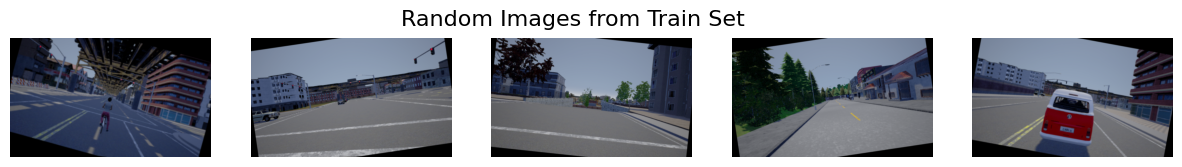

In [10]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def plot_random_images(image_dir, num_images=5, set_type='Train'):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f"Random Images from {set_type} Set", fontsize=16)

    for i in range(num_images):
        random_image = random.choice(os.listdir(image_dir))
        image_path = os.path.join(image_dir, random_image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.subplots_adjust(top= 1.5)
    plt.show()

# Plot random images from augmented train set
plot_random_images(train_images_path, set_type='Train')

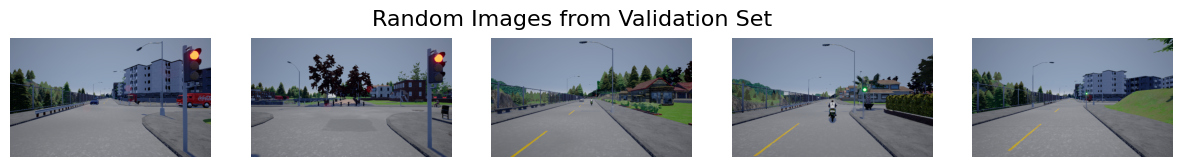

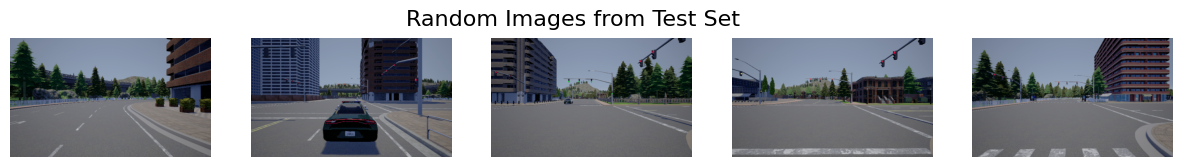

In [11]:
# Plot random images from augmented validation set
plot_random_images(val_images_path, set_type='Validation')

# Plot random images from test set
plot_random_images(test_images_path, set_type = 'Test')

### Step 6: Train YOLOv8 for object detection, print accuracy, and IOU for this pre-trained model.

In [ ]:
!nvidia-smi

Tue Mar 26 23:03:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.5/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
%cd /content/drive/MyDrive/datasets/yolo-dataset

/content/drive/MyDrive/datasets/yolo-dataset


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data= /content/data.yaml epochs=10 imgsz=224 plots=True

100% 21.5M/21.5M [00:00<00:00, 153MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/data.yaml, epochs=10, patience=50, batch=16, imgsz=224, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

In [ ]:
!pwd

/content/drive/MyDrive/datasets/yolo-dataset


In [ ]:
!ls runs/detect/train

args.yaml					    results.csv		   val_batch1_labels.jpg
confusion_matrix.png				    results.png		   val_batch1_pred.jpg
events.out.tfevents.1711509652.5bd0c687bf63.4495.0  train_batch0.jpg	   val_batch2_labels.jpg
F1_curve.png					    train_batch1.jpg	   val_batch2_pred.jpg
P_curve.png					    train_batch2.jpg	   weights
PR_curve.png					    val_batch0_labels.jpg
R_curve.png					    val_batch0_pred.jpg


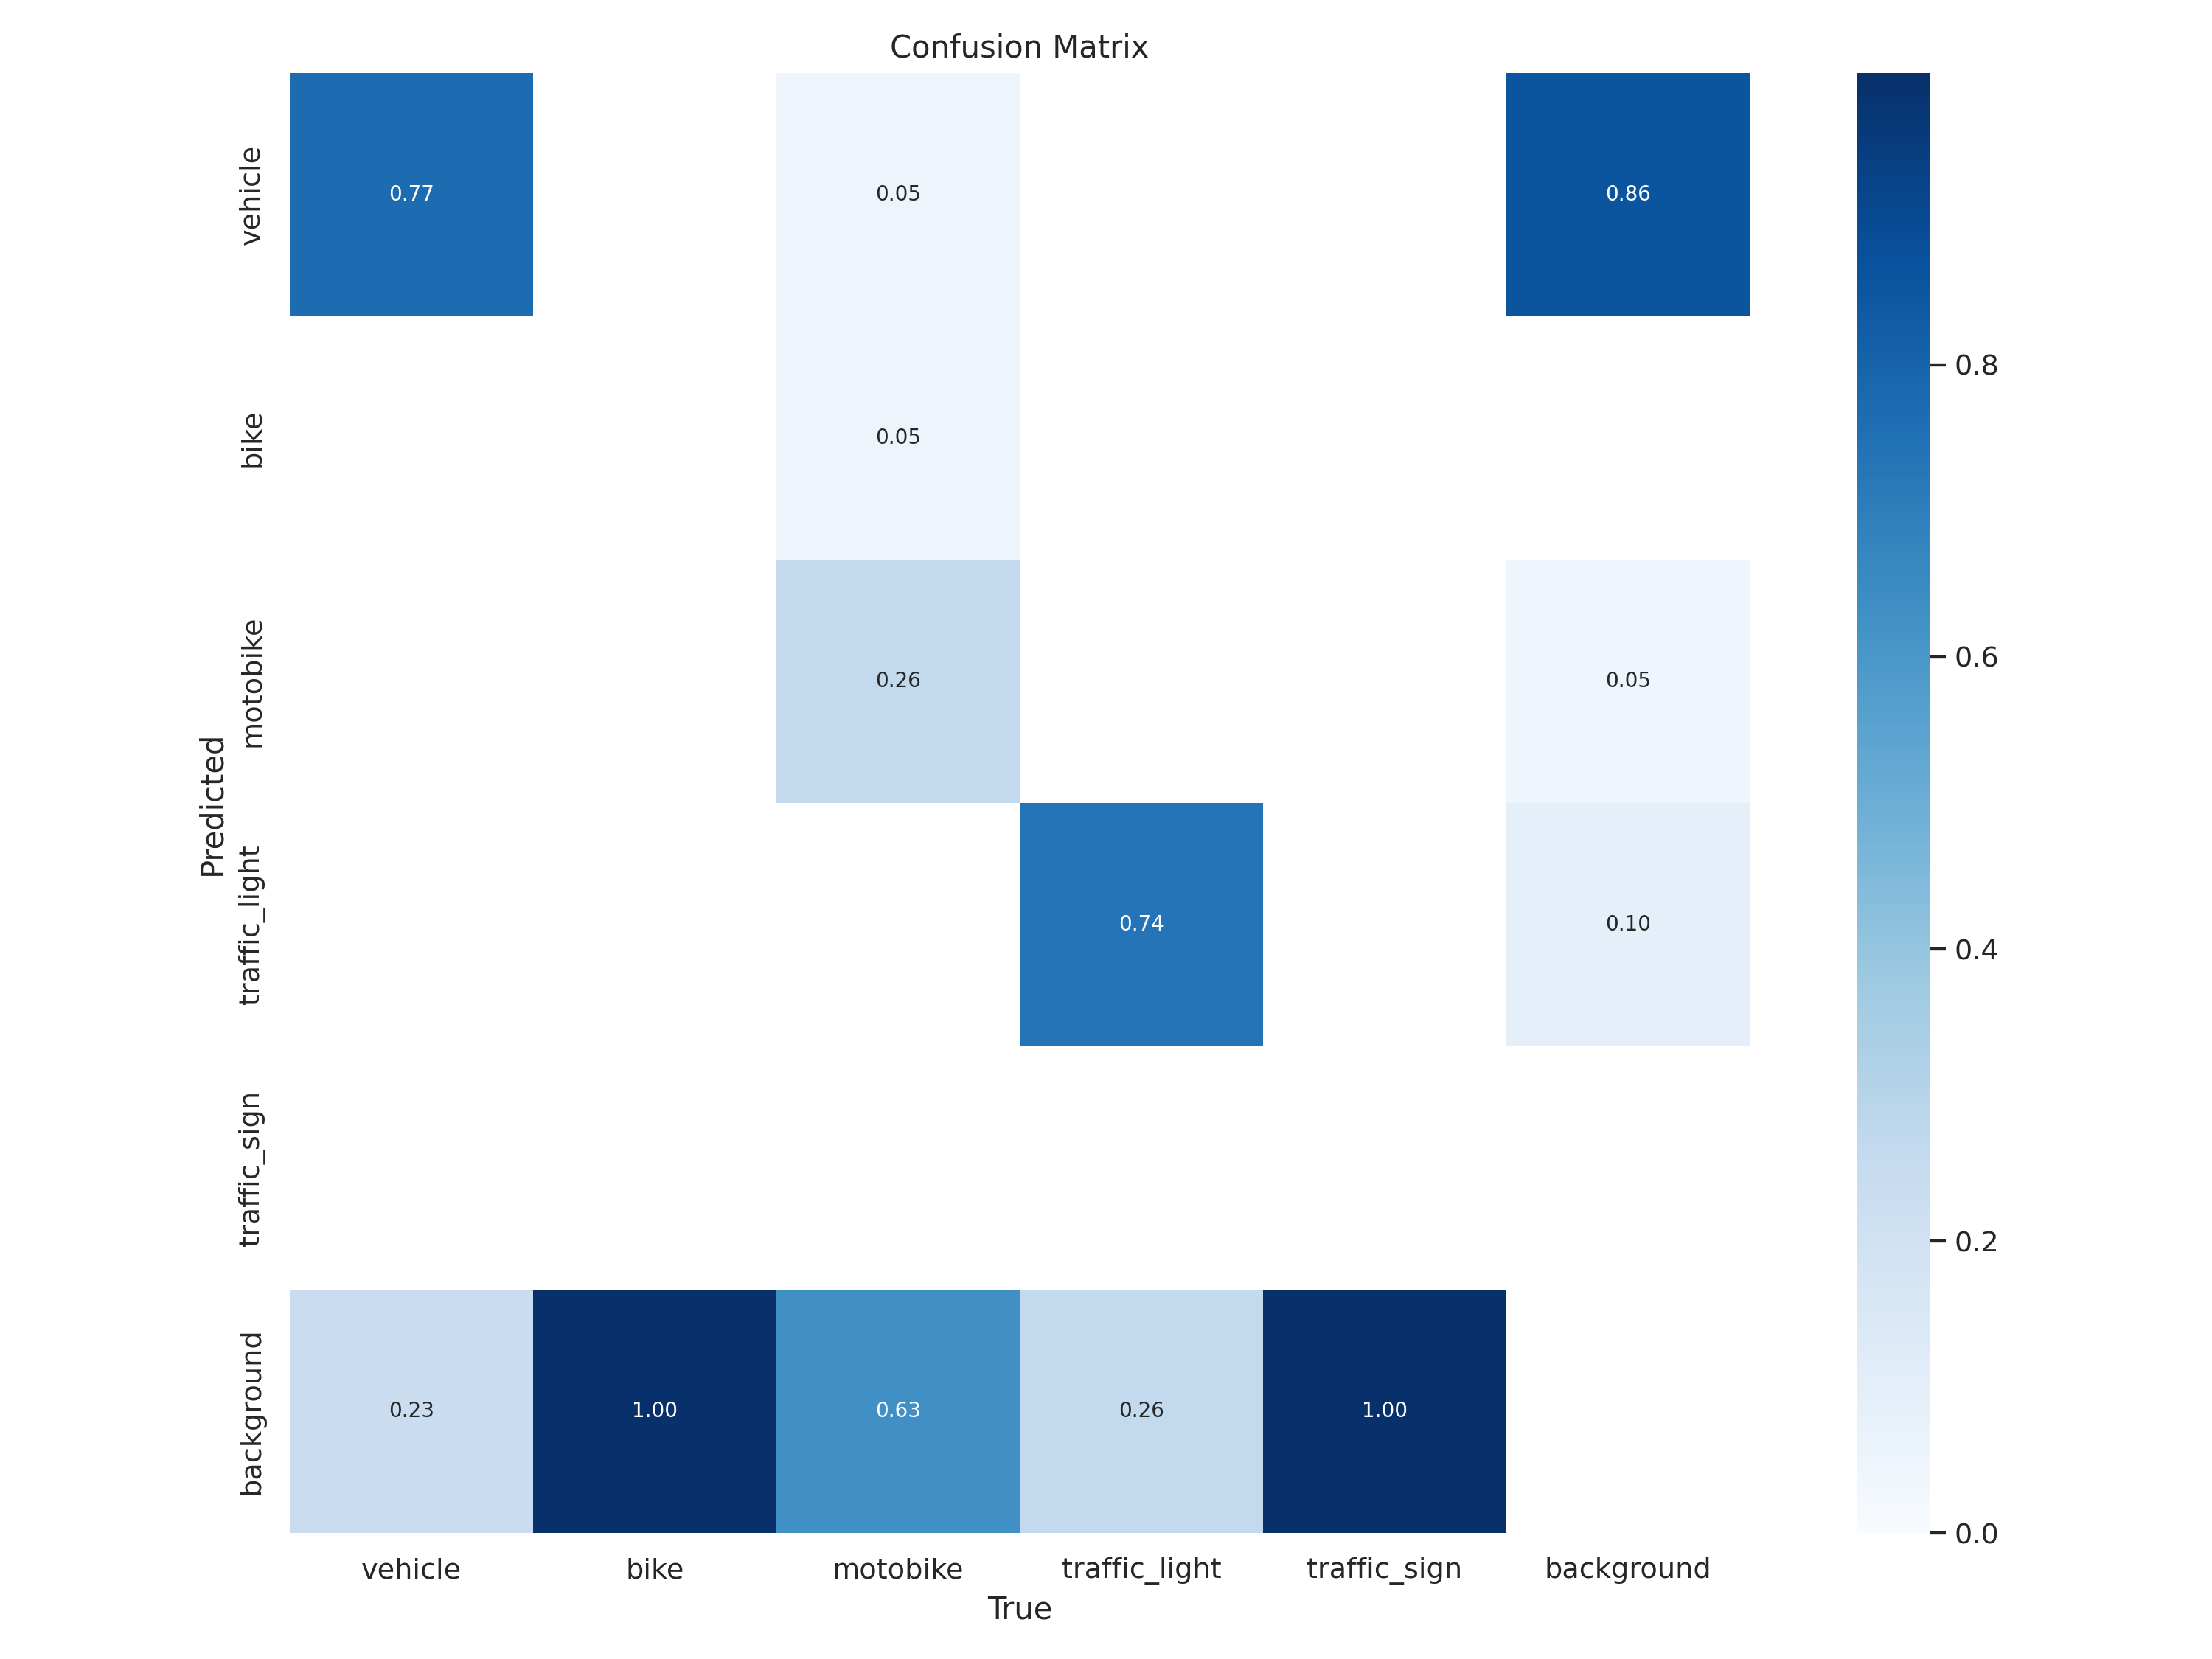

In [ ]:
Image(filename='/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/train/confusion_matrix.png', width=600)

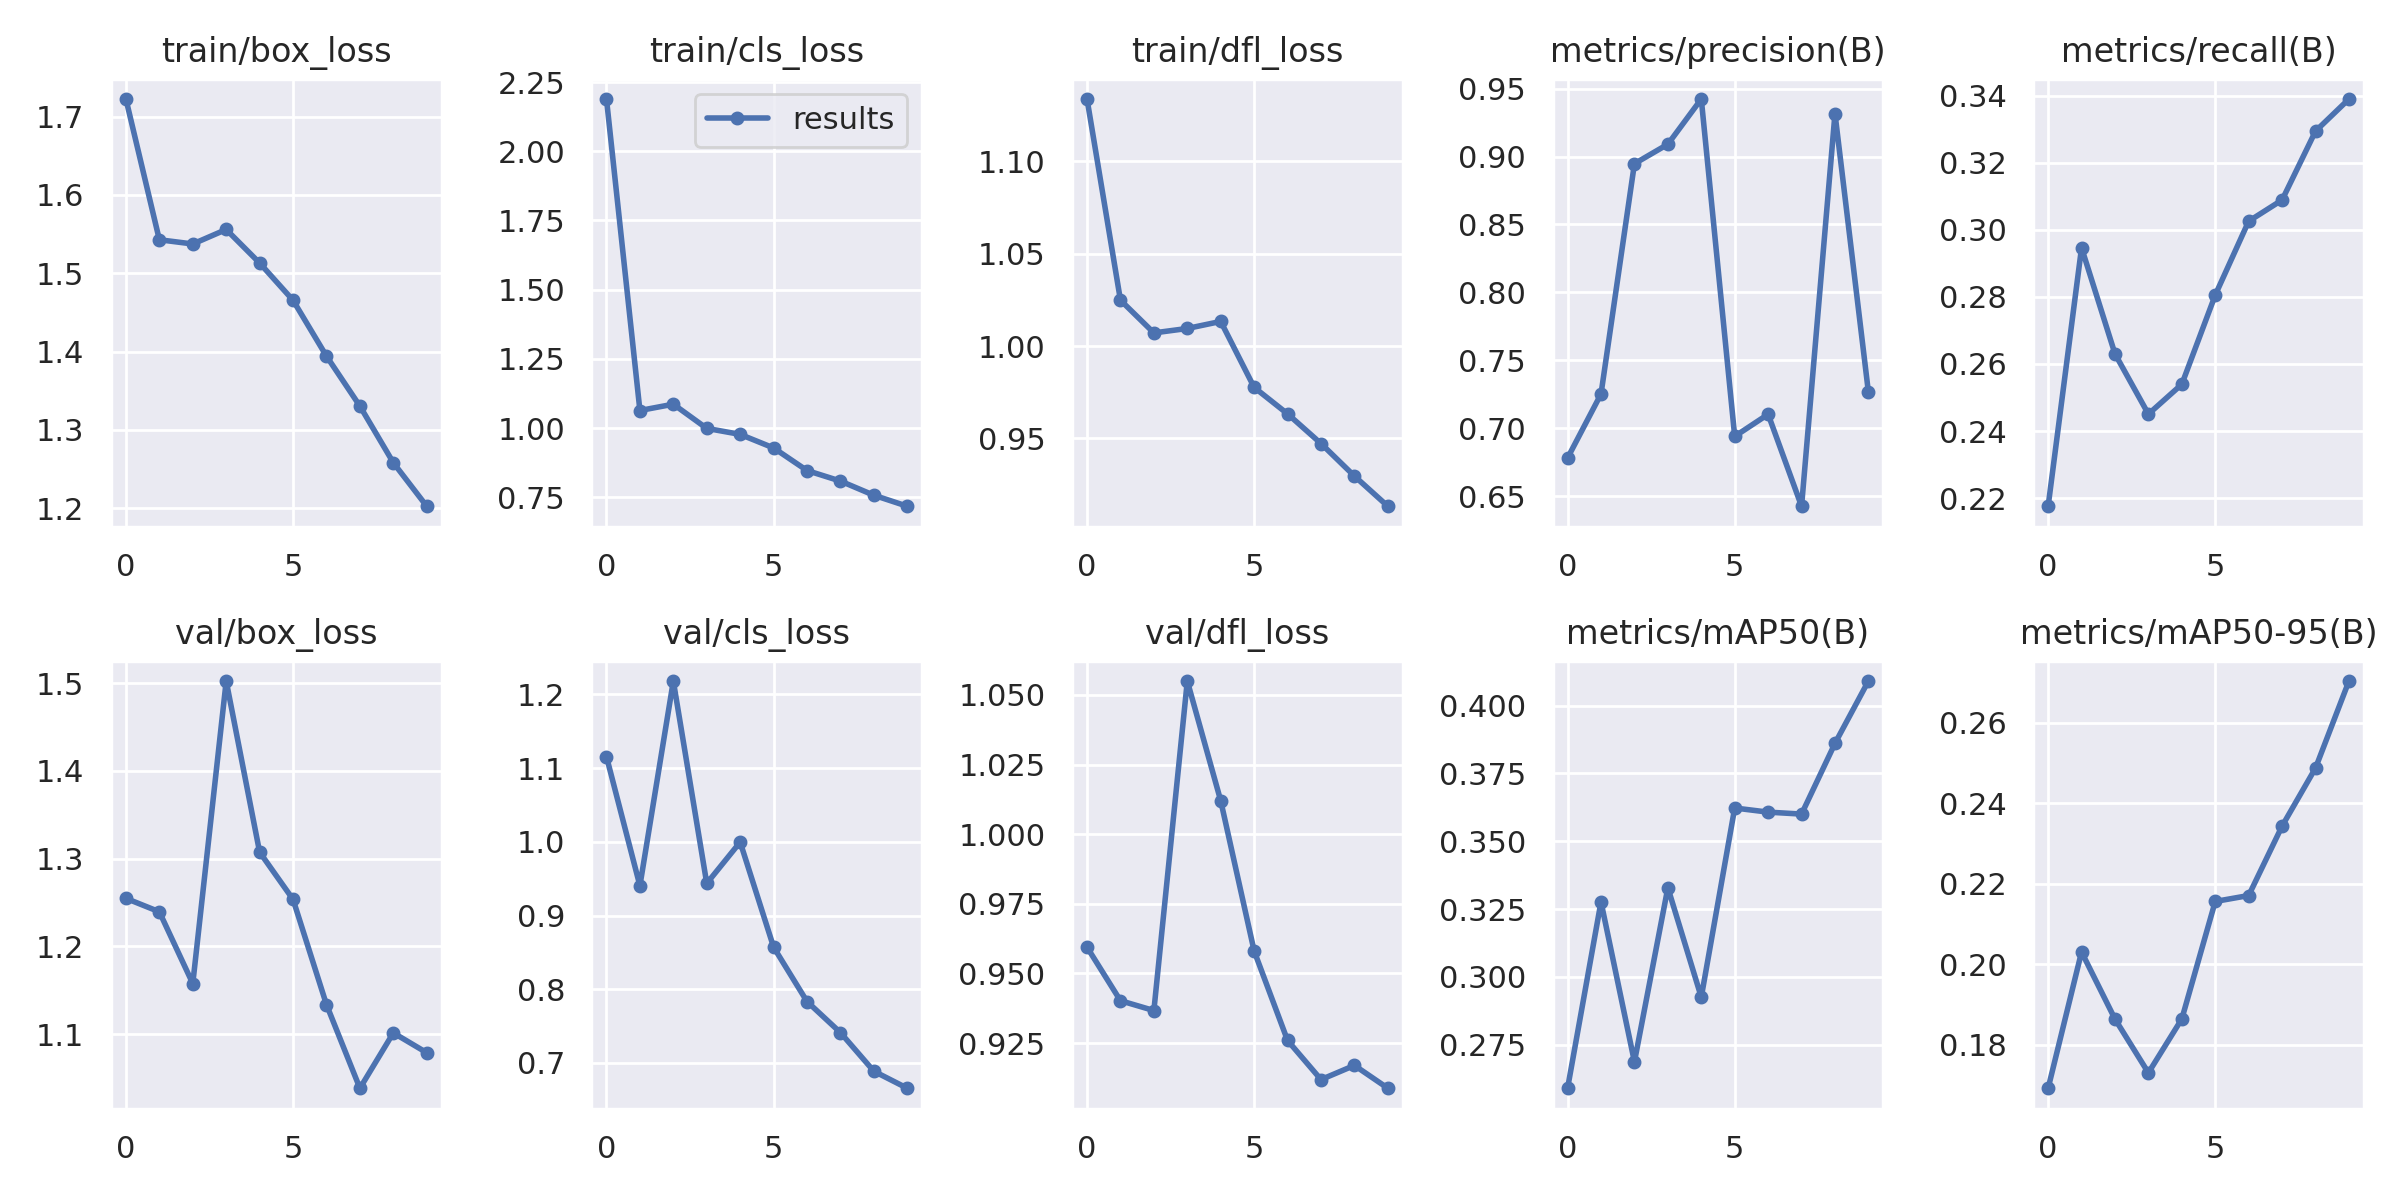

In [ ]:
Image(filename='/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/train/results.png', width=600)

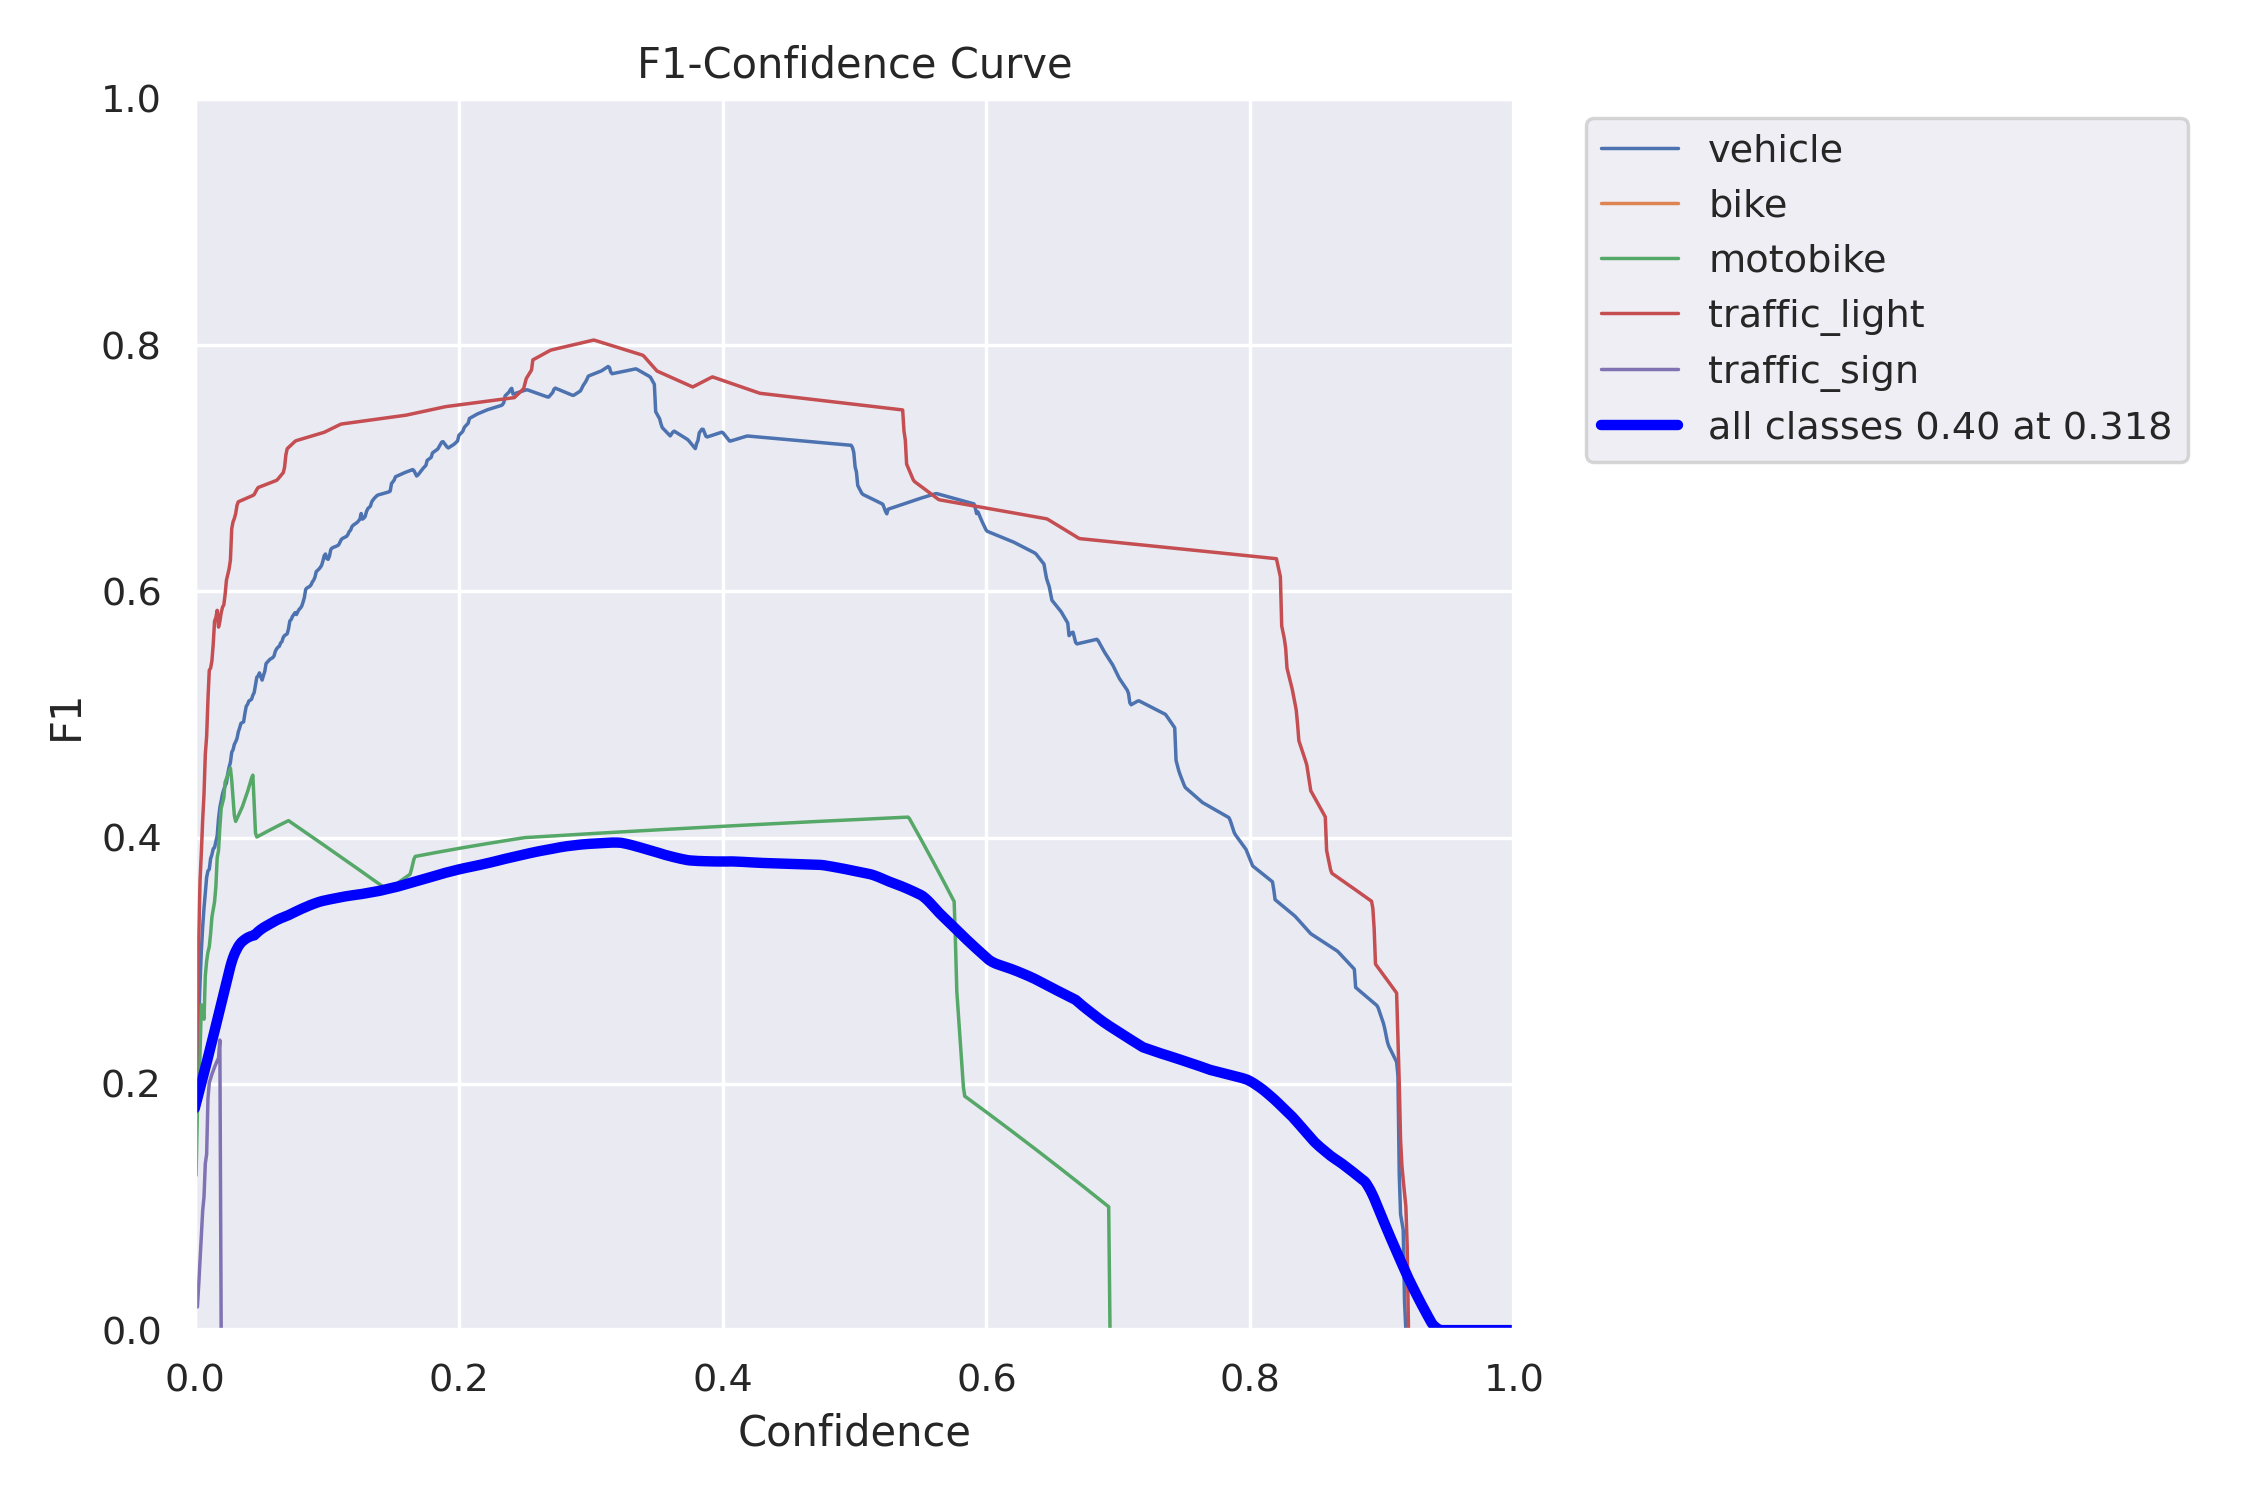

In [ ]:
Image(filename= '/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/train/F1_curve.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/train/weights/best.pt data=/content/data.yaml

2024-03-27 03:28:51.412438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 03:28:51.412494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 03:28:51.414598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 03:28:52.896147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/datasets/yolo-dataset/val/labels.cac

## Inference

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/datasets/yolo-dataset/test/images save_txt save=True

2024-03-27 04:27:58.005119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 04:27:58.005170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 04:27:58.006681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 04:27:59.036564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs
image 1/199 /content/drive/MyDrive/datasets/yolo-dataset/test/images/Town

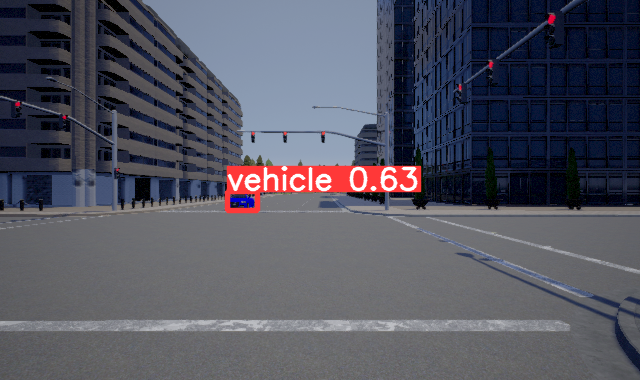

In [ ]:
Image(filename= '/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/predict/Town05_002580.png', width=600)

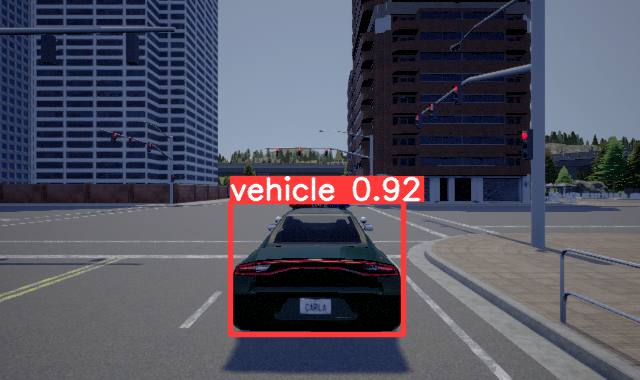

In [ ]:
Image(filename= '/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/predict/Town05_005940.png', width=600)

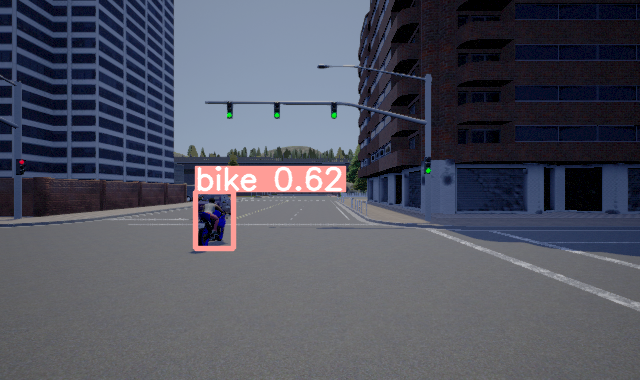

In [ ]:
Image(filename= '/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/predict/Town05_006660.png', width=600)

## IOU

In [ ]:
import os

# Path to the folders containing predicted and ground truth labels
predicted_boxes_folder = "/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/predict2/labels"
ground_truth_boxes_folder = "/content/drive/MyDrive/datasets/yolo-dataset/test/labels"

# Function to read bounding box coordinates from a label file
def read_bbox_from_file(label_file_path):
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
        bounding_boxes = []
        for line in lines:
            # Format: class_number x_center y_center width height
            class_number, x_center, y_center, width, height = map(float, line.strip().split())
            bounding_boxes.append((class_number, x_center, y_center, width, height))
        return bounding_boxes

# Function to calculate Intersection over Union (IOU) between two bounding boxes
def calculate_iou(bbox1, bbox2):
    # Extract coordinates
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Convert to coordinates of top-left and bottom-right corners
    x1_tl, y1_tl = x1 - w1 / 2, y1 - h1 / 2
    x2_tl, y2_tl = x2 - w2 / 2, y2 - h2 / 2
    x1_br, y1_br = x1 + w1 / 2, y1 + h1 / 2
    x2_br, y2_br = x2 + w2 / 2, y2 + h2 / 2

    # Calculate intersection coordinates
    x_intersection_tl = max(x1_tl, x2_tl)
    y_intersection_tl = max(y1_tl, y2_tl)
    x_intersection_br = min(x1_br, x2_br)
    y_intersection_br = min(y1_br, y2_br)

    # Calculate intersection area
    intersection_area = max(0, x_intersection_br - x_intersection_tl) * max(0, y_intersection_br - y_intersection_tl)

    # Calculate union area
    bbox1_area = w1 * h1
    bbox2_area = w2 * h2
    union_area = bbox1_area + bbox2_area - intersection_area

    # Calculate IOU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

# Iterate through predicted label files
for predicted_label_file in os.listdir(predicted_boxes_folder):
    if predicted_label_file.endswith(".txt"):
        # Construct paths to predicted and ground truth label files
        predicted_label_path = os.path.join(predicted_boxes_folder, predicted_label_file)
        ground_truth_label_path = os.path.join(ground_truth_boxes_folder, predicted_label_file)

        # Read bounding box coordinates from label files
        predicted_bboxes = read_bbox_from_file(predicted_label_path)
        ground_truth_bboxes = read_bbox_from_file(ground_truth_label_path)

        # Calculate IOU for each pair of predicted and ground truth bounding boxes
        ious = []
        for pred_bbox in predicted_bboxes:
            pred_class, pred_x, pred_y, pred_w, pred_h = pred_bbox
            for gt_bbox in ground_truth_bboxes:
                gt_class, gt_x, gt_y, gt_w, gt_h = gt_bbox
                # Calculate IOU
                iou = calculate_iou((pred_x, pred_y, pred_w, pred_h), (gt_x, gt_y, gt_w, gt_h))
                ious.append(iou)

        # Calculate average IOU for the image
        avg_iou = sum(ious) / len(ious) if ious else 0

        print(f"IOU for {predicted_label_file}: {avg_iou}")


IOU for Town05_002100.txt: 0.06845136501011605
IOU for Town05_002160.txt: 0.06845136501011605
IOU for Town05_002220.txt: 0.06845136501011605
IOU for Town05_002280.txt: 0.0598723433698481
IOU for Town05_002400.txt: 0.06354810238305371
IOU for Town05_002460.txt: 0.06354810238305371
IOU for Town05_002520.txt: 0.06354810238305371
IOU for Town05_002580.txt: 0.06354810238305371
IOU for Town05_002640.txt: 0.06354810238305371
IOU for Town05_003660.txt: 0.056053443233399856
IOU for Town05_004020.txt: 0.07427000466902281
IOU for Town05_004080.txt: 0.13145648487105882
IOU for Town05_004440.txt: 0
IOU for Town05_004620.txt: 0.12335732218239749
IOU for Town05_004680.txt: 0.07287157072246234
IOU for Town05_004740.txt: 0.08736395675312827
IOU for Town05_004800.txt: 0.06685214778511313
IOU for Town05_004860.txt: 0.059884207854781935
IOU for Town05_004920.txt: 0.06897194665845238
IOU for Town05_005340.txt: 0.07404700334448167
IOU for Town05_005520.txt: 0.06348840878862495
IOU for Town05_005580.txt: 0.0

In [ ]:
def read_boxes_from_file(file_path, image_width, image_height):
    # Example implementation to read bounding boxes from a file
    # You should replace this with your actual implementation
    # Here, we assume each line in the file contains a bounding box in the format "x_min y_min x_max y_max"
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            box = [float(value) for value in values]
            boxes.append(box)
    return boxes

def calculate_iou_boxes(box1, box2):
    # box1 and box2 should be in the format [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate area of predicted and ground truth boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IOU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

def calculate_average_iou(actual_folder, predicted_folder, image_width, image_height):
    total_iou = 0
    pair_count = 0
    actual_files = os.listdir(actual_folder)

    for actual_file in actual_files:
        actual_file_path = os.path.join(actual_folder, actual_file)
        predicted_file_path = os.path.join(predicted_folder, actual_file)

        if os.path.isfile(predicted_file_path):
            actual_boxes = read_boxes_from_file(actual_file_path, image_width, image_height)
            predicted_boxes = read_boxes_from_file(predicted_file_path, image_width, image_height)

            for actual_box in actual_boxes:
                for predicted_box in predicted_boxes:
                    total_iou += calculate_iou_boxes(actual_box, predicted_box)
                    pair_count += 1

    if pair_count > 0:
        average_iou = total_iou / pair_count
    else:
        average_iou = 0

    return average_iou

# Example usage:
actual_folder = "/content/drive/MyDrive/datasets/yolo-dataset/test/labels"
predicted_folder = "/content/drive/MyDrive/datasets/yolo-dataset/runs/detect/predict2/labels"
image_width = 800  # Replace with actual image width
image_height = 600  # Replace with actual image height

average_iou = calculate_average_iou(actual_folder, predicted_folder, image_width, image_height)
print("Average IOU score:", average_iou)


Average IOU score: 0.11735060138929572
